Implementing a test based on the accumulated persistence function from Biscio 2022.

In [1]:
# Uncomment for interactive plots
# %matplotlib widget

%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import scipy.signal as sg
import librosa
import gudhi as gd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# import networkx as nx
from itertools import combinations

from mcsm_benchs.SignalBank import SignalBank
from mcsm_benchs.Benchmark import Benchmark

plt.rcParams['xtick.labelsize'] = 6.0
plt.rcParams['ytick.labelsize'] = 6.0
plt.rcParams['axes.labelsize'] =  7.0

In [3]:
# # Load the signals
# # x,fs = librosa.load('speech/example_2.wav', sr=8000)
# # x,fs = librosa.load('speech/6_female.wav', sr=8000)
# x,fs = librosa.load('instruments/cello.wav', sr=8000) 

# x, fs = librosa.load(librosa.ex('trumpet'), duration=1, sr=8000)
# N = len(x)
# Audio(x/np.max(np.abs(x)), rate=fs)

In [4]:
# rng
np.random.seed(1) 

# signal parameters
N = 2**8
Nsub=None
sbank = SignalBank(N=N,)
# s = sbank.signal_linear_chirp()
x = sbank.signal_mc_double_cos_chirp()

In [5]:
# Define the mixture
snr = 10
# np.random.seed(0)
noise = np.random.randn(N,)
signal = Benchmark.sigmerge(x,noise,snr)
# Audio(signal,rate=fs)

### Hypothesis test

In [6]:
from src.utilities.utils import apf_mc_test
Nfft = 2*N
output_dict = apf_mc_test(signal, Nfft=Nfft, hdim=1, return_all=True, nsim=199)
print(output_dict['rejectH0'])

True


In [7]:
apf_signal = output_dict['apf_obs']
apf_noise = output_dict['apf_noise']
apf_mean = output_dict['apf_mean']
ms = output_dict['ms']
nsims = output_dict['nsims']

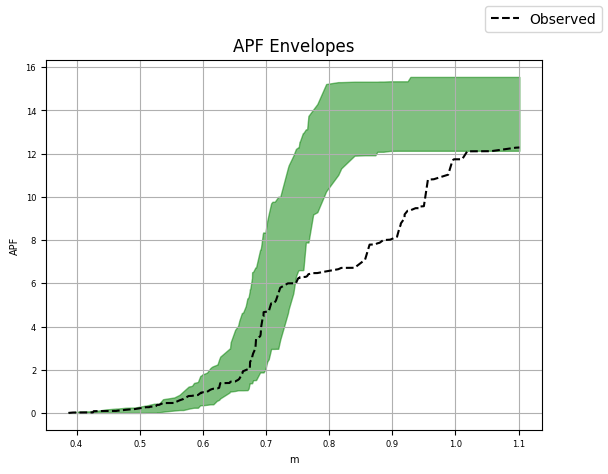

In [8]:
# Envelopes
upper_env = np.max(apf_noise,axis=0)
lower_env = np.min(apf_noise,axis=0)

fig2,ax = plt.subplots(1,1)
ax.fill_between(np.sqrt(ms),lower_env,upper_env, color='green',alpha=0.5)
ax.plot(np.sqrt(ms),apf_signal, '--k', label='Observed')
ax.set_ylabel('APF')
ax.set_xlabel('m')
ax.set_title('APF Envelopes')
fig2.legend()
ax.grid(True)

Text(0.5, 0, 'm')

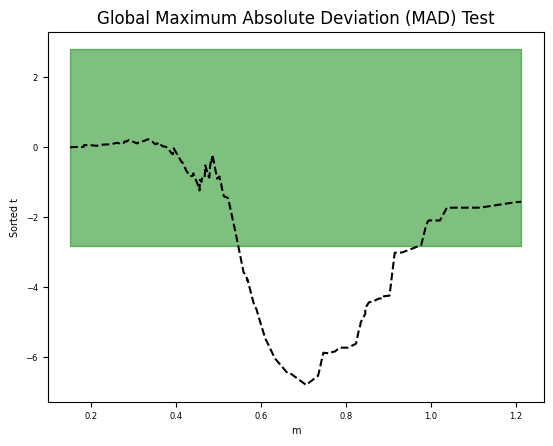

In [9]:
m_max = np.max(ms)
pnorm = np.inf
t0 = np.linalg.norm(apf_signal[ms<=m_max]-apf_mean[ms<=m_max],ord=pnorm)

tj = np.zeros((nsims,))
for j in range(nsims): 
    tj[j] = np.linalg.norm(apf_noise[j][ms<=m_max]-apf_mean[ms<=m_max],ord=pnorm)

alpha = 0.05
k = int(alpha*(nsims+1))
tj_sorted = np.sort(tj)[::-1]
fig3, ax = plt.subplots(1,1,)
ax.plot(ms,apf_signal[ms<=m_max]-apf_mean[ms<=m_max],'k--')
ax.fill_between(ms,-tj_sorted[k]*np.ones_like(ms),tj_sorted[k]*np.ones_like(ms), color='green', alpha=0.5)
ax.set_title('Global Maximum Absolute Deviation (MAD) Test')
ax.set_ylabel('Sorted t')
ax.set_xlabel('m')


/tmp/ipykernel_41964/1068573.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
/tmp/ipykernel_41964/1068573.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels())


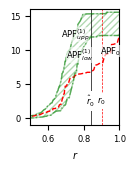

In [10]:
r_max_dif = np.max(lower_env-apf_signal)
ind_max_dif = np.argmax(lower_env-apf_signal)
ms2 = np.sqrt(ms)

fig, ax = plt.subplots(1,1, figsize=(1.15,1.5))
ax.fill_between(ms2, lower_env,upper_env, facecolor='w', edgecolor='g', alpha=.3, hatch='/////')
ax.plot(ms2,apf_signal,'r--', linewidth=1.0)

# ax.plot([ms2[ind_max_dif],ms2[ind_max_dif]],[-0.1,lower_env[ind_max_dif]],'k',linewidth=0.5)

# axins = inset_axes(ax, width=0.55, height=0.55, loc=2)
# axins.imshow(output_dict['spectrogram'], origin='lower')
# # axins.imshow(np.sqrt(output_dict['spectrogram']), origin='lower')
# axins.axis('off')
# fig.canvas.draw()
# axins.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

label_size = 6.0

# Indicate the estimation of r_0
ax.plot([ms2[ind_max_dif],ms2[ind_max_dif]],
# [0.5,output_dic['envelope_lo'][output_dic['ind_max_dif']]/np.pi*2],
[-1,16],
'k', 
linewidth=0.5)

# Near optimal r_0:
ax.plot([0.9,0.9],
[-1,16],
'r--', 
linewidth=0.5)

ax.text(0.9,
        2.5,
        r'$r_{0}$',
        fontsize=6.0, 
        horizontalalignment='center',
        verticalalignment='center',
        backgroundcolor = 'w',
        bbox={'facecolor':'white', 'edgecolor':'none','pad':1.5})  

# r_0 estimation
ax.text(ms2[ind_max_dif],
        2.5,
        r'$\hat{r}_{0}$',
        fontsize=6.0, 
        horizontalalignment='center',
        verticalalignment='center',
        backgroundcolor = 'w',
        bbox={'facecolor':'white', 'edgecolor':'none','pad':1.5})

# Label the curves:
# Upper envelope:
ax.plot(ms2,upper_env, 'g-.', alpha=.5, linewidth=1.0)
xind = np.where(ms2>=0.75)[0][0]
xcoord = ms2[xind]
angle = 0 #180/np.pi*np.arctan((upper_env[xind+1]-upper_env[xind])/(ms2[xind+1]-ms2[xind]))
t = ax.text(xcoord,upper_env[xind]*1.0,
        r'APF$^{(1)}_{upp}$', 
        fontsize=label_size,
        rotation=angle,
        horizontalalignment='center', 
        verticalalignment='center',
        backgroundcolor = 'w',
        # bbox={'facecolor':'white', 'edgecolor':'none','pad':0.01},
        )
t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.01))

# Lower envelope:
ax.plot(ms2,lower_env, 'g-.', alpha=.5, linewidth=1.0)
xind = np.where(ms2>=0.78)[0][0]
xcoord = ms2[xind]
angle = 0 #180/np.pi*np.arctan((lower_env[xind+1]-lower_env[xind])/(ms2[xind+1]-ms2[xind]))

t = ax.text(xcoord,lower_env[xind],
        r'APF$^{(1)}_{low}$', 
        rotation=angle,
        fontsize=label_size, 
        horizontalalignment='center',
        verticalalignment='center',        
        backgroundcolor = 'w',
        # bbox={'facecolor':'white', 'edgecolor':'none','pad':0.01},
        )
t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.01))

# Observation:
xind = np.where(ms2>=0.95)[0][0]
xcoord = ms2[xind]
angle = 0 #180/np.pi*np.arctan((apf_signal[xind+2]-apf_signal[xind])/(np.sqrt(ms)[xind+2]-np.sqrt(ms)[xind]))
t = ax.text(xcoord,apf_signal[xind],
        r'APF$_{0}$', 
        rotation=angle,
        fontsize=label_size,
        horizontalalignment='center',
        verticalalignment='center',
        backgroundcolor = 'w',
        # bbox={'facecolor':'white', 'edgecolor':'none','pad':0},
        )
t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.01))

ax.set_xlim([0.5, 1.0])
ax.set_ylim([-1, 16])
ax.set_xticklabels(ax.get_xticklabels())
ax.set_yticklabels(ax.get_yticklabels())
ax.set(xlabel=r'$r$',ylabel='')


fig.savefig('figures/adaptive_thr_scale_APF.pdf', 
            dpi=900, 
            transparent=False, 
            bbox_inches='tight',
                pad_inches = 0,
                )